# Forecasting Solar Energy Generation in Germany

## Table of Contents

* [1. Exploratory Data Analysis](#eda)
    * [1.1. Downloading data](#download)
    * [1.2. Data Exploration](#exploration)
    * [1.3. Creating the German dataset](#german)
    * [1.4. Plots for the daily German dataset](#german_plots)

* [2. Theory and functions for ARIMA models](#arima)
    * [2.0. Box-Jenkins method](#box)
    * [2.1. Identification](#identification)
        * [2.1.1. ADF test](#adf)
        * [2.1.2. ACF and PACF](#acf)
    * [2.2. Estimation](#estimation)
        * [2.2.1. AIC and BIC](#aic)
        * [2.2.2. PACF/ACF for different model](#pacf)
    * [2.3. Model diagnostics](#diagnostics)
    * [2.4. Forecasting](#forecasting)

* [3. Time Series Analysis for WEEKLY Solar Generation in Germany](#ts0)
    * [3.1. Identification](#identification_ts0)
    * [3.2. Estimation](#estimation_ts0)
    * [3.3. Model diagnostics](#diagnostics_ts0)
    * [3.4. Seasonal Differencing](#seasonal_ts0)
    * [3.5. Forecasting](#forecasting_ts0)

----

* [3. Time Series Analysis for Solar Generation in Germany](#ts1)

* [4. Time Series Analysis for rolling mean of Solar Generation in Germany (30 days)](#ts2)

* [5. WEEKLY TS](#ts3)

* [5. (!!!) Seasonal TS](#seasonal)

* [The End](#final)



In [1]:
import opendatasets as od
import re
import os

from datetime import datetime
from datetime import timezone
from datetime import date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


<a id="eda"></a>

# 1. Exploratory Data Analysis


<a id="download"></a>

## 1.1. Downloading data

Sourse: https://data.open-power-system-data.org/time_series/2020-10-06

"This data package contains different kinds of timeseries data relevant for power system modelling, 
namely electricity prices, electricity consumption (load) as well as wind and solar power generation 
and capacities. The data is aggregated either by country, control area or bidding zone. Geographical 
coverage includes the EU and some neighbouring countries. All variables are provided in hourly 
resolution. Where original data is available in higher resolution (half-hourly or quarter-hourly), 
it is provided in separate files. This package version only contains data provided by TSOs and power 
exchanges via ENTSO-E Transparency, covering the period 2015-mid 2020. See previous versions for 
historical data from a broader range of sources. All data processing is conducted in Python/pandas 
and has been documented in the Jupyter notebooks linked below."

In [2]:
opsd_url = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv'

od.download(opsd_url)

130342912it [00:52, 2497387.70it/s]                                             


In [6]:
# import zipfile

# path_to_zip_file = 'opsd-time_series-2020-10-06.zip'
# directory_to_extract_to = 'opsd-time_series-2020-10-06/'

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [3]:
path_to_csv = 'time_series_60min_singleindex.csv'

df = pd.read_csv(path_to_csv)
df.head()

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
3,2015-01-01T02:00:00Z,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
4,2015-01-01T03:00:00Z,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN


<a id="exploration"></a>

## 1.2. Exploration

In [4]:
df.dtypes

utc_timestamp                            object
cet_cest_timestamp                       object
AT_load_actual_entsoe_transparency      float64
AT_load_forecast_entsoe_transparency    float64
AT_price_day_ahead                      float64
                                         ...   
SK_load_forecast_entsoe_transparency    float64
SK_solar_generation_actual              float64
SK_wind_onshore_generation_actual       float64
UA_load_actual_entsoe_transparency      float64
UA_load_forecast_entsoe_transparency    float64
Length: 300, dtype: object

In [5]:
df.isnull().sum()

utc_timestamp                               0
cet_cest_timestamp                          0
AT_load_actual_entsoe_transparency          1
AT_load_forecast_entsoe_transparency        1
AT_price_day_ahead                      17556
                                        ...  
SK_load_forecast_entsoe_transparency        3
SK_solar_generation_actual                391
SK_wind_onshore_generation_actual       40722
UA_load_actual_entsoe_transparency      24766
UA_load_forecast_entsoe_transparency    24988
Length: 300, dtype: int64

In [6]:
# removing the big dataset

os.remove(path_to_csv)

<a id="german"></a>

## 1.3. Creating the German dataset

In [7]:
german_columns = [col for col in list(df) 
                  if re.search('DE_', col) 
                  and not re.search('DE_LU_', col)
                  and not re.search('_amprion_', col)
                  and not re.search('_tennet_', col)
                  and not re.search('_transnetbw_', col)
                  and not re.search('_50hertz_', col)
                 ]
german_columns

['DE_load_actual_entsoe_transparency',
 'DE_load_forecast_entsoe_transparency',
 'DE_solar_capacity',
 'DE_solar_generation_actual',
 'DE_solar_profile',
 'DE_wind_capacity',
 'DE_wind_generation_actual',
 'DE_wind_profile',
 'DE_wind_offshore_capacity',
 'DE_wind_offshore_generation_actual',
 'DE_wind_offshore_profile',
 'DE_wind_onshore_capacity',
 'DE_wind_onshore_generation_actual',
 'DE_wind_onshore_profile']

* DE_load_actual_entsoe_transparency
    - Description: Total load in Germany in MW as published on ENTSO-E Transparency Platform
* DE_load_forecast_entsoe_transparency
    - Description: Day-ahead load forecast in Germany in MW as published on ENTSO-E Transparency Platform


* DE_solar_capacity
    - Description: Electrical capacity of solar in Germany in MW
* DE_solar_generation_actual
    - Description: Actual solar generation in Germany in MW
* DE_solar_profile
    - Description: Share of solar capacity producing in Germany


* DE_wind_capacity
    - Description: Electrical capacity of wind in Germany in MW
* DE_wind_generation_actual
    - Description: Actual wind generation in Germany in MW
* DE_wind_profile
    - Description: Share of wind capacity producing in Germany


* DE_wind_offshore_capacity
    - Description: Electrical capacity of wind_offshore in Germany in MW
* DE_wind_offshore_generation_actual
    - Description: Actual wind_offshore generation in Germany in MW
* DE_wind_offshore_profile
    - Description: Share of wind_offshore capacity producing in Germany


* DE_wind_onshore_capacity
    - Description: Electrical capacity of wind_onshore in Germany in MW
* DE_wind_onshore_generation_actual
    - Description: Actual wind_onshore generation in Germany in MW
* DE_wind_onshore_profile
    - Description: Share of wind_onshore capacity producing in Germany


in MW == in megawatt

DE_wind_capacity == DE_wind_offshore_capacity + DE_wind_onshore_capacity

XXX_profile == XXX_generation_actual / XXX_capacity 
    for XXX in [DE_solar, DE_wind, DE_wind_offshore, DE_wind_onshore]

XXX_generation_actual == generation for last hour


What is **wind_offshore** and **wind_onshore**?

- **Offshore wind** farms generate electricity from wind blowing across the sea. They are considered more efficient than onshore wind farms, thanks to the higher speed of winds, greater consistency and lack of physical interference that the land or human-made objects can present.

- **Onshore wind** energy is the power that’s generated by wind turbines located on land driven by the natural movement of the air. You’ll often see onshore wind farms in fields or more rural areas, as they’re usually constructed in less-populated areas where buildings and obstacles don’t interrupt the air.

Link: https://www.nationalgrid.com/stories/energy-explained/onshore-vs-offshore-wind-energy#


In [8]:
ger_df = df[['cet_cest_timestamp'] + german_columns]
ger_df.head()

,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile
0,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,NaN,27913.0,NaN,NaN,667.0,NaN,NaN,27246.0,NaN,NaN
1,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,NaN,27913.0,8852.0,0.3171,667.0,517.0,0.7744,27246.0,8336.0,0.3059
2,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,NaN,27913.0,9054.0,0.3244,667.0,514.0,0.7710,27246.0,8540.0,0.3134
3,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,NaN,27913.0,9070.0,0.3249,667.0,518.0,0.7761,27246.0,8552.0,0.3139
4,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,NaN,27913.0,9163.0,0.3283,667.0,520.0,0.7793,27246.0,8643.0,0.3172


In [10]:
def fix_col_1(col):
    if re.findall('DE_(.*)', col):
        return re.findall('DE_(.*)', col)[0]
    else:
        return col

def fix_col_2(col):
    if re.findall('(.*)_entsoe_transparency', col):
        return re.findall('(.*)_entsoe_transparency', col)[0]
    else:
        return col


de_columns = list(ger_df)

for col in de_columns:
#     print()
#     print(col)
#     print(de_columns)
    ger_df[fix_col_1(fix_col_2(col))] = ger_df[col]
    if col != fix_col_1(fix_col_2(col)):
#         print('Need to delete: ', col)
        ger_df.drop(col, axis=1, inplace=True)

pct_columns = [col for col in list(ger_df) if re.search('_profile', col)]
ger_df.drop(pct_columns, axis=1, inplace=True)

ger_df.head()

/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_51453/3498251137.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_df[fix_col_1(fix_col_2(col))] = ger_df[col]
/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_51453/3498251137.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_df.drop(pct_columns, axis=1, inplace=True)


,cet_cest_timestamp,load_actual,load_forecast,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual
0,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,27913.0,NaN,667.0,NaN,27246.0,NaN
1,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,27913.0,8852.0,667.0,517.0,27246.0,8336.0
2,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,27913.0,9054.0,667.0,514.0,27246.0,8540.0
3,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,27913.0,9070.0,667.0,518.0,27246.0,8552.0
4,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,27913.0,9163.0,667.0,520.0,27246.0,8643.0


In [11]:
ger_df.shape

(50401, 11)

In [12]:
ger_df.isnull().sum()

cet_cest_timestamp                    0
load_actual                           1
load_forecast                        25
solar_capacity                     6601
solar_generation_actual             104
wind_capacity                      6601
wind_generation_actual               75
wind_offshore_capacity             6601
wind_offshore_generation_actual      75
wind_onshore_capacity              6601
wind_onshore_generation_actual       73
dtype: int64

In [13]:
# saving the original dataset for Germany

ger_df.to_csv('germany_wind_and_solar.csv', sep='\t', encoding='utf-8', index=False)

In [15]:
# ger_df2 = pd.read_csv('germany_wind_and_solar.csv', sep='\t', encoding='utf-8')
# ger_df2.head()

,cet_cest_timestamp,load_actual,load_forecast,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual
0,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,27913.0,NaN,667.0,NaN,27246.0,NaN
1,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,27913.0,8852.0,667.0,517.0,27246.0,8336.0
2,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,27913.0,9054.0,667.0,514.0,27246.0,8540.0
3,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,27913.0,9070.0,667.0,518.0,27246.0,8552.0
4,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,27913.0,9163.0,667.0,520.0,27246.0,8643.0


In [16]:
# create daily column

ger_df2 = ger_df[list(ger_df)]

ger_df2['cet_dttm'] = ger_df2['cet_cest_timestamp'].apply(lambda x: datetime.fromisoformat(x[:-5]))
ger_df2['cet_dt'] = pd.to_datetime(pd.to_datetime(ger_df2['cet_dttm'], utc=True).dt.date)
# monday of this week
ger_df2['cet_week_dt'] = ger_df2['cet_dt'] - pd.to_timedelta(ger_df2['cet_dt'].dt.dayofweek, unit='d')
# first day of this month
ger_df2['cet_month_dt'] = ger_df2['cet_dt'].apply(lambda x: x.replace(day=1))
ger_df2.head()

,cet_cest_timestamp,load_actual,load_forecast,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual,cet_dttm,cet_dt,cet_week_dt,cet_month_dt
0,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,27913.0,NaN,667.0,NaN,27246.0,NaN,2015-01-01 00:00:00,2015-01-01,2014-12-29,2015-01-01
1,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,27913.0,8852.0,667.0,517.0,27246.0,8336.0,2015-01-01 01:00:00,2015-01-01,2014-12-29,2015-01-01
2,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,27913.0,9054.0,667.0,514.0,27246.0,8540.0,2015-01-01 02:00:00,2015-01-01,2014-12-29,2015-01-01
3,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,27913.0,9070.0,667.0,518.0,27246.0,8552.0,2015-01-01 03:00:00,2015-01-01,2014-12-29,2015-01-01
4,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,27913.0,9163.0,667.0,520.0,27246.0,8643.0,2015-01-01 04:00:00,2015-01-01,2014-12-29,2015-01-01


In [17]:
ger_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   cet_cest_timestamp               50401 non-null  object        
 1   load_actual                      50400 non-null  float64       
 2   load_forecast                    50376 non-null  float64       
 3   solar_capacity                   43800 non-null  float64       
 4   solar_generation_actual          50297 non-null  float64       
 5   wind_capacity                    43800 non-null  float64       
 6   wind_generation_actual           50326 non-null  float64       
 7   wind_offshore_capacity           43800 non-null  float64       
 8   wind_offshore_generation_actual  50326 non-null  float64       
 9   wind_onshore_capacity            43800 non-null  float64       
 10  wind_onshore_generation_actual   50328 non-null  float64  

In [18]:
ger_df2_h = ger_df2[list(ger_df2)]
ger_df2_h = ger_df2_h.set_index('cet_dttm')
ger_df2_h.head()

,cet_cest_timestamp,load_actual,load_forecast,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual,cet_dt,cet_week_dt,cet_month_dt
cet_dttm,,,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01T00:00:00+0100,NaN,NaN,37248.0,NaN,27913.0,NaN,667.0,NaN,27246.0,NaN,2015-01-01,2014-12-29,2015-01-01
2015-01-01 01:00:00,2015-01-01T01:00:00+0100,41151.0,39723.0,37248.0,NaN,27913.0,8852.0,667.0,517.0,27246.0,8336.0,2015-01-01,2014-12-29,2015-01-01
2015-01-01 02:00:00,2015-01-01T02:00:00+0100,40135.0,38813.0,37248.0,NaN,27913.0,9054.0,667.0,514.0,27246.0,8540.0,2015-01-01,2014-12-29,2015-01-01
2015-01-01 03:00:00,2015-01-01T03:00:00+0100,39106.0,38490.0,37248.0,NaN,27913.0,9070.0,667.0,518.0,27246.0,8552.0,2015-01-01,2014-12-29,2015-01-01
2015-01-01 04:00:00,2015-01-01T04:00:00+0100,38765.0,38644.0,37248.0,NaN,27913.0,9163.0,667.0,520.0,27246.0,8643.0,2015-01-01,2014-12-29,2015-01-01


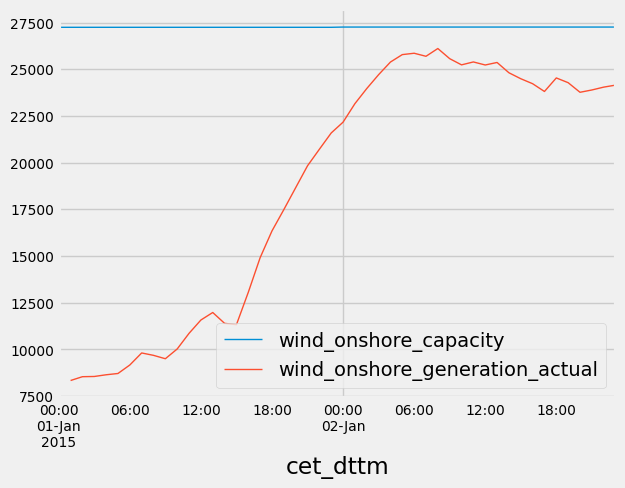

In [19]:
# Plot your the discoveries time series
ax = ger_df2_h['2015-01-01':'2015-01-02'][['wind_onshore_capacity', 'wind_onshore_generation_actual']].plot(fontsize=10, linewidth=1)

# Add a red vertical line
# ax.axvline('2020-01-01', color='red', linestyle='--')

# Add a green horizontal line
# ax.axhline(20000, color='green', linestyle='--')

plt.show()


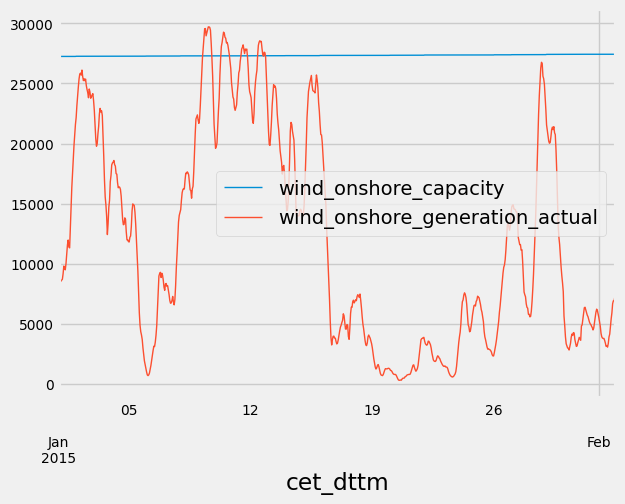

In [20]:
# Plot your the discoveries time series
ax = ger_df2_h['2015-01-01':'2015-02-01'][['wind_onshore_capacity', 'wind_onshore_generation_actual']].plot(fontsize=10, linewidth=1)

# Add a red vertical line
# ax.axvline('2020-01-01', color='red', linestyle='--')

# Add a green horizontal line
# ax.axhline(20000, color='green', linestyle='--')

plt.show()


### 1.3.1. Daily dataset 

In [21]:
ger_daily_generation_df = ger_df2[['cet_dt',
    'solar_generation_actual',
    'wind_generation_actual',
    'wind_offshore_generation_actual','wind_onshore_generation_actual'
]].groupby(['cet_dt']).sum()

ger_daily_generation_df.head(10)

,solar_generation_actual,wind_generation_actual,wind_offshore_generation_actual,wind_onshore_generation_actual
cet_dt,,,,
2015-01-01,17098.0,302693.0,11992.0,290701.0
2015-01-02,7757.0,601950.0,10329.0,591622.0
2015-01-03,7237.0,469167.0,12120.0,457046.0
2015-01-04,19982.0,390566.0,11540.0,379028.0
2015-01-05,26522.0,227370.0,7748.0,219622.0
2015-01-06,32888.0,109591.0,6887.0,102704.0
2015-01-07,17114.0,221294.0,10694.0,210599.0
2015-01-08,8599.0,432866.0,12334.0,420529.0
2015-01-09,6822.0,644152.0,8803.0,635350.0


In [22]:
ger_daily_generation_df_slice = ger_daily_generation_df['2017':'2020']
ger_daily_generation_df_slice

,solar_generation_actual,wind_generation_actual,wind_offshore_generation_actual,wind_onshore_generation_actual
cet_dt,,,,
2017-01-01,35291.0,310156.0,51756.0,258398.0
2017-01-02,12479.0,290985.0,60886.0,230100.0
2017-01-03,9351.0,650021.0,74353.0,575666.0
2017-01-04,12814.0,699663.0,70048.0,629615.0
2017-01-05,20797.0,277103.0,34279.0,242823.0
...,...,...,...,...
2020-09-27,96856.0,219488.0,83758.0,135732.0
2020-09-28,111763.0,79293.0,21262.0,58028.0
2020-09-29,88967.0,75793.0,20280.0,55517.0


In [23]:
ger_wind_df_slice = ger_daily_generation_df_slice[['wind_generation_actual']]

# Print out summary statistics
# print(ger_wind_df_slice.describe())
# print()

# print(ger_wind_df_slice.describe().loc['max'])
# print(ger_wind_df_slice.describe().loc['min'])

In [24]:
ger_solar_df_slice = ger_daily_generation_df_slice[['solar_generation_actual']]

# Print out summary statistics
print(ger_solar_df_slice.describe())
# print()

# print(ger_solar_df_slice.describe().loc['max'])
# print(ger_solar_df_slice.describe().loc['min'])

       solar_generation_actual
count              1370.000000
mean             117144.535766
std               72968.444844
min                   0.000000
25%               47188.250000
50%              116462.000000
75%              177396.500000
max              290429.000000


### 1.3.2. Weekly dataset 

In [25]:
ger_weekly_generation_df = ger_df2[['cet_week_dt',
    'solar_generation_actual',
    'wind_generation_actual',
    'wind_offshore_generation_actual','wind_onshore_generation_actual'
]].groupby(['cet_week_dt']).sum()

ger_weekly_generation_df.head(10)

,solar_generation_actual,wind_generation_actual,wind_offshore_generation_actual,wind_onshore_generation_actual
cet_week_dt,,,,
2014-12-29,52074.0,1764376.0,45981.0,1718397.0
2015-01-05,132229.0,2895813.0,62520.0,2833286.0
2015-01-12,172051.0,2642826.0,69014.0,2573810.0
2015-01-19,97130.0,468323.0,30111.0,438209.0
2015-01-26,130888.0,1683353.0,59824.0,1623530.0
2015-02-02,254387.0,1311524.0,55712.0,1255809.0
2015-02-09,300430.0,1001276.0,65459.0,935818.0
2015-02-16,385706.0,1404748.0,81511.0,1323237.0
2015-02-23,359899.0,1765579.0,93694.0,1671877.0


In [26]:
ger_weekly_generation_df.shape

(301, 4)

### 1.3.3. Monthly dataset 

In [27]:
ger_monthly_generation_df = ger_df2[['cet_month_dt',
    'solar_generation_actual',
    'wind_generation_actual',
    'wind_offshore_generation_actual','wind_onshore_generation_actual'
]].groupby(['cet_month_dt']).sum()

ger_monthly_generation_df.head(10)

,solar_generation_actual,wind_generation_actual,wind_offshore_generation_actual,wind_onshore_generation_actual
cet_month_dt,,,,
2015-01-01,559692.0,9334624.0,261446.0,9073168.0
2015-02-01,1288413.0,5148466.0,282754.0,4865705.0
2015-03-01,2858576.0,6923411.0,431976.0,6491432.0
2015-04-01,4435384.0,5002872.0,378485.0,4624380.0
2015-05-01,4411604.0,5262785.0,565139.0,4697640.0
2015-06-01,4552821.0,4095101.0,481563.0,3613528.0
2015-07-01,4917511.0,5863167.0,707917.0,5155259.0
2015-08-01,4612575.0,3858013.0,570967.0,3287053.0
2015-09-01,3226533.0,5547629.0,768406.0,4779224.0


In [28]:
ger_monthly_generation_df.shape

(70, 4)

<a id="german_plots"></a>

## 1.4. Plots for the daily German dataset

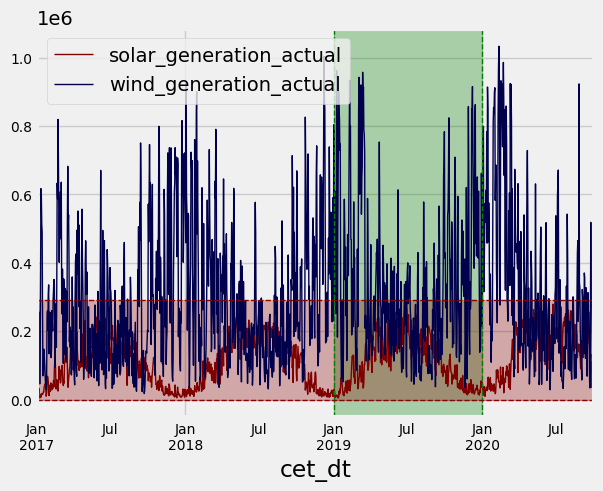

In [29]:

ax = ger_daily_generation_df_slice[[
    'solar_generation_actual','wind_generation_actual'
]].plot(fontsize=10, linewidth=1, colormap='seismic_r') # color='blue'


# Add vertical lines
ax.axvline('2019-01-01', color='green', linestyle='--', linewidth=1)
ax.axvline('2020-01-01', color='green', linestyle='--', linewidth=1)

# Add a vertical red shaded region
ax.axvspan('2019-01-01', '2020-01-01', color='green', alpha=0.3)


solar_max = ger_daily_generation_df_slice['solar_generation_actual'].max()
solar_min = ger_daily_generation_df_slice['solar_generation_actual'].min()

# Add a green horizontal line
ax.axhline(solar_max, color='darkred', linestyle='--', linewidth=1)
ax.axhline(solar_min, color='darkred', linestyle='--', linewidth=1)

# Add a horizontal green shaded region
ax.axhspan(solar_min, solar_max, color='darkred', alpha=0.3)

plt.show()

In [30]:
def plot_rolling_mean_std(df, column, window_size):
    
    # Compute the 52 weeks rolling mean and rolling standard deviation of the wind_generation_actual
    ma = df[[column]].rolling(window=window_size).mean()
    mstd = df[[column]].rolling(window=window_size).std()

    # Add the upper and lower bound columns to the ma DataFrame
    ma['upper'] = ma[column] + (2 * mstd[column])
    ma['lower'] = ma[column] - (2 * mstd[column])
    
    fig, ax = plt.subplots(figsize = (8,6))

    c = sns.lineplot(data = ma, ax=ax, linewidth=1)
    line = c.get_lines()
    plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='darkblue', alpha=.2)

    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel(column, fontsize=10)
    ax.set_title(f'Rolling mean and variance of {column}\nin Germany from 2018 to 2020'.format(column=column), fontsize=10)
    plt.xticks(rotation = 45, size=10)
    plt.yticks(size=10)
    plt.legend(fontsize="10")

    plt.show()

    return 1


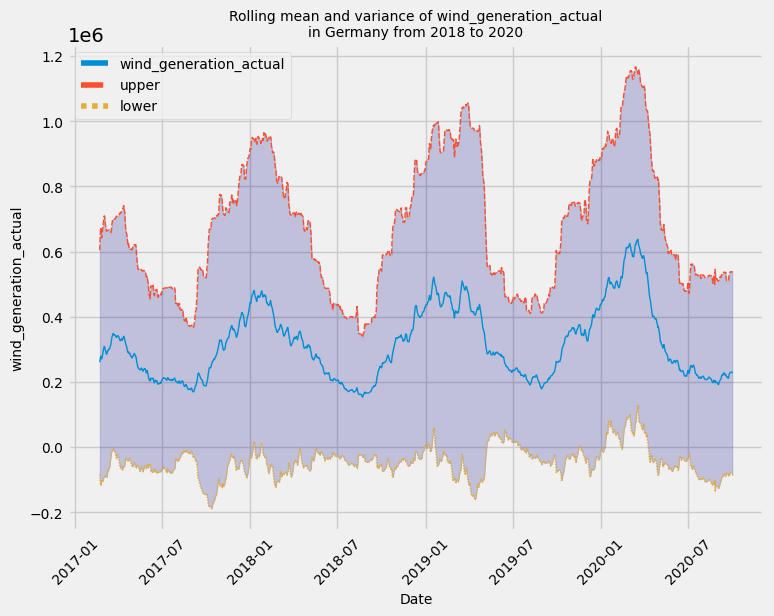

1

In [31]:
plot_rolling_mean_std(ger_daily_generation_df_slice, 'wind_generation_actual', window_size=52)


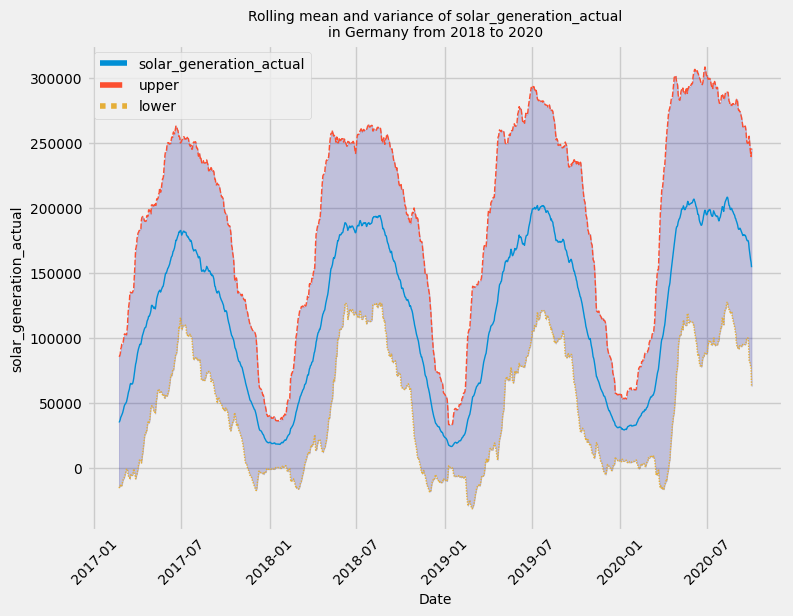

1

In [32]:
plot_rolling_mean_std(ger_daily_generation_df_slice, 'solar_generation_actual', window_size=52)


In [33]:
def plot_by_month(df):

    index_month = df.index.month
    mean_df_by_month = df.groupby(index_month).mean()

    ax = mean_df_by_month.plot(fontsize=6, linewidth=1)

    plt.legend(fontsize=10)
    plt.show()
    
    return 1

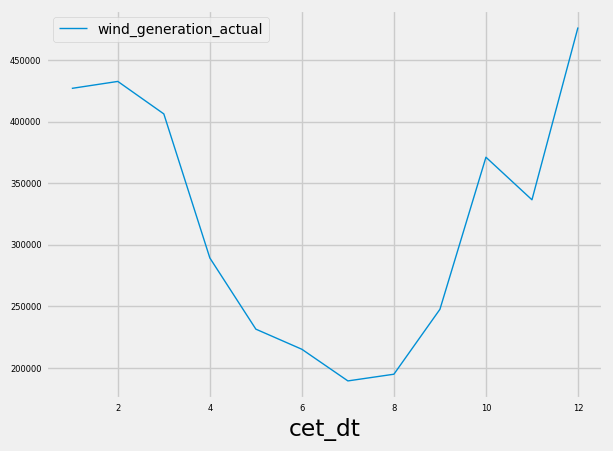

1

In [34]:
plot_by_month(ger_daily_generation_df_slice[['wind_generation_actual']])

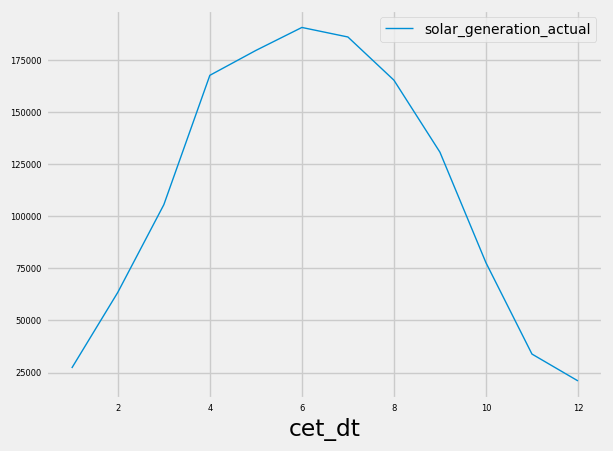

1

In [35]:
plot_by_month(ger_daily_generation_df_slice[['solar_generation_actual']])

### Histograms

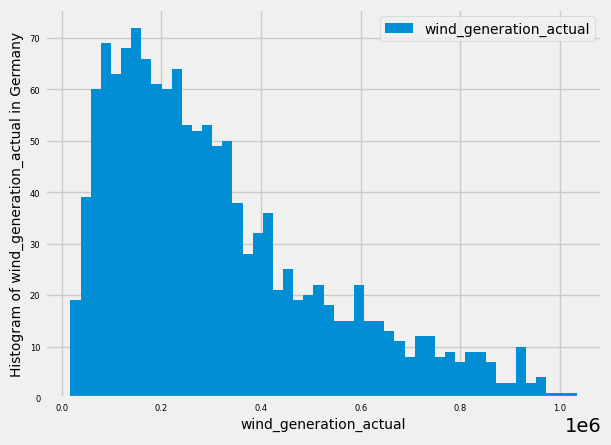

In [36]:
# Generate a histogram
ax = ger_daily_generation_df_slice[['wind_generation_actual']].plot(kind='hist', bins=50, fontsize=6)

# Set the labels and display the plot
ax.set_xlabel('wind_generation_actual', fontsize=10)
ax.set_ylabel('Histogram of wind_generation_actual in Germany', fontsize=10)
plt.legend(fontsize=10)
plt.show()

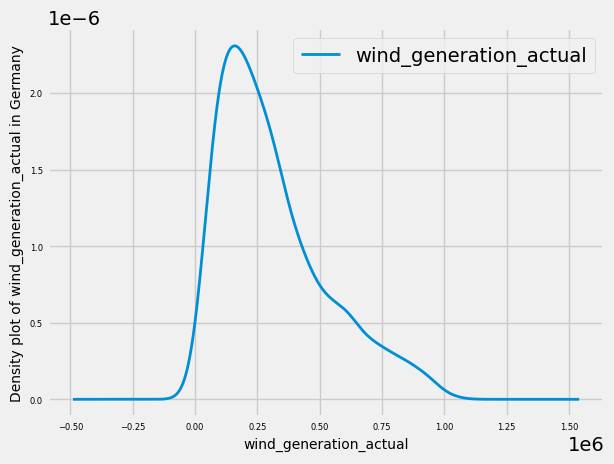

In [37]:
# Display density plot
ax = ger_daily_generation_df_slice[['wind_generation_actual']].plot(kind='density', linewidth=2, fontsize=6)

# Annotate labels
ax.set_xlabel('wind_generation_actual', fontsize=10)
ax.set_ylabel('Density plot of wind_generation_actual in Germany', fontsize=10)
plt.show()

### MULTIPLE TS

In [38]:
ger_wind_solar_df = ger_daily_generation_df[list(ger_daily_generation_df)][['wind_generation_actual', 'solar_generation_actual']]
ger_wind_solar_df_slice = ger_wind_solar_df['2017':'2020']


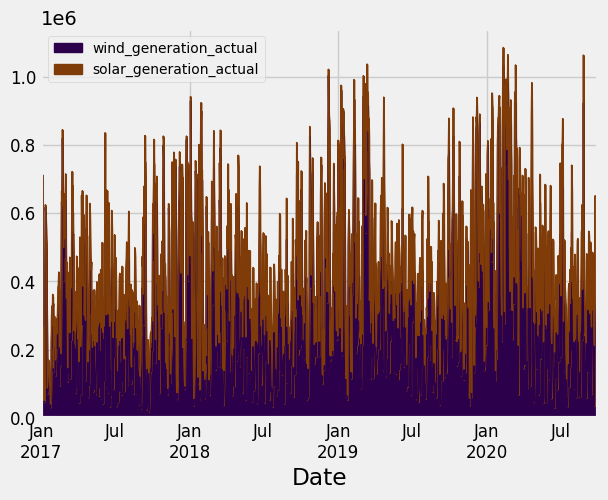

In [39]:
# Plot a STACKED area chart
ax = ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']].plot.area(colormap='PuOr_r', fontsize=12, linewidth=1, stacked=True) # , stacked=False

ax.set_xlabel('Date')
ax.legend(fontsize=10)
plt.show()

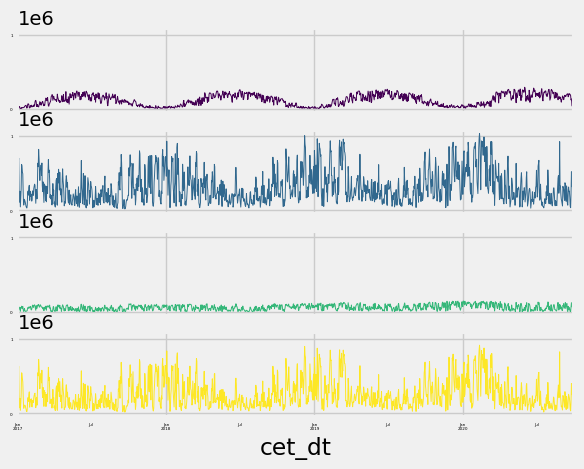

In [40]:
# Create a facetted graph with 4 rows and 1 columns
ax = ger_daily_generation_df_slice.plot(subplots=True,
                      layout=(4,1),
                      sharex=True,
                      sharey=True,
                      colormap='viridis', 
                      linewidth=0.7,
                      fontsize=3,
                      legend=False)

plt.show()

### CORRELATIONS

In [41]:
print(ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']].corr(method='pearson'))


                         wind_generation_actual  solar_generation_actual
wind_generation_actual                 1.000000                -0.427539
solar_generation_actual               -0.427539                 1.000000


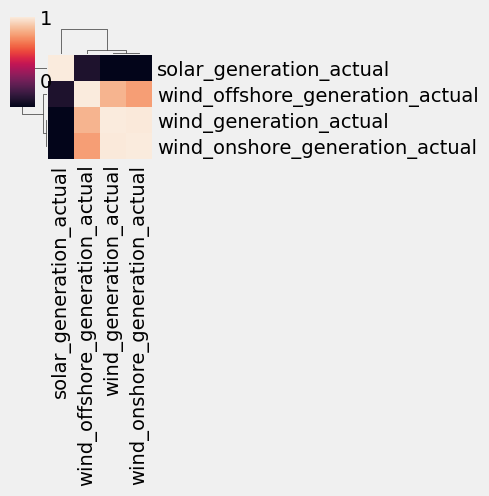

In [42]:
# Get correlation matrix
corr_wind_solar = ger_daily_generation_df_slice.corr(method='pearson')

fig = sns.clustermap(corr_wind_solar,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(5, 5))
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

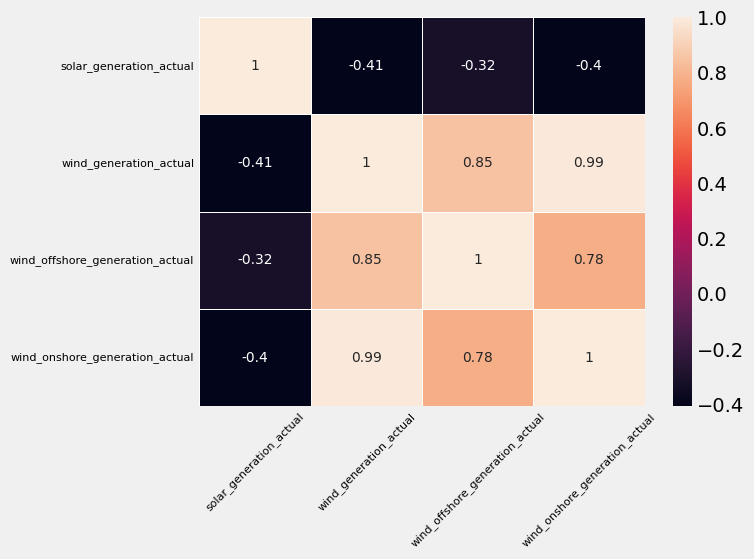

In [43]:
# Get correlation matrix
corr_wind_solar = ger_daily_generation_df_slice.corr(method='spearman')

sns.heatmap(corr_wind_solar,
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8) 
plt.show()

In [385]:
# ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']]

<a id="arima"></a>

# 2. Theory and functions for ARIMA models

In [44]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


<a id="box"></a>

## 2.0. Box-Jenkins method

**ARIMA** model:

- **AR** = autoregressive

- **I** = integrated

- **MA** = moving average

order=(p,d,q):

- p - number of autoregressive lags
- d - order of differencing
- q - number of moving average lags

The **Auto-Regressive (AR) model** assumes that the current value (y_t) is *dependent on previous values* (y_(t-1), y_(t-2), …). Because of this assumption, we can build a linear regression model. To figure out the order of an AR model, you need to look at the **PACF**.

The **Moving Average (MA) model** assumes that the current value (y_t) is *dependent on the error terms including the current error* (𝜖_t, 𝜖_(t-1),…). Because error terms are random, there’s no linear relationship between the current value and the error terms. To figure out the order of an MA model, you need to look at the **ACF**.

Link: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

Steps of the **Box-Jenkins method**:

- 1. Identification *(Is the time series stationary? What dierencing/transform will make it stationary?)*
    - Run Dicky-Fuller test
    - See ADF statistic and p-value
    - Plot ACF and PACF
    - Finally choose d
- 2. Estimation *(What values of p and q are most promising?)*
    - Loop over p and q values for ARIMA(p,d,q) to choose p, q.
- 3. Diagnostics
    - Plot 4 diagostics plots
    - See summary
- 4. Decision
    - Is the model ok?
        - If no, repeat 1-3 (for example, for seasonal ARIMA).
        - If yes, see 5.
- 5. Production
    - results.get_forecast()

In [45]:
def plot_seasonal_components(ts, period):
    
    decomp_weekly = seasonal_decompose(ts, period=period)

    fig, axes = plt.subplots(4, 1, sharex=True)

    decomp_weekly.observed.plot(ax=axes[0], legend=False, color='r', linewidth=1)
    axes[0].set_ylabel('Observed', fontsize=12)

    decomp_weekly.trend.plot(ax=axes[1], legend=False, color='g', linewidth=1)
    axes[1].set_ylabel('Trend', fontsize=12)

    decomp_weekly.seasonal.plot(ax=axes[2], legend=False, linewidth=1)
    axes[2].set_ylabel('Seasonal', fontsize=12)

    decomp_weekly.resid.plot(ax=axes[3], legend=False, color='k', linewidth=1)
    axes[3].set_ylabel('Residual', fontsize=12)
    
    return 1

From the decomposition above we can conclude:

- If there is a **upward trend**, the time series is **not stationary**. 
    - Since our data is not stationary, we need to answer *What differencing will make it stationary?* For this we will use our obtain_adf_kpss_results function to find out how many times we need to apply differencing in order to make this time series stationary. This will be our parameter **d** for the ARIMA model.

- From the **seasonal** component we can observe that the model is **additive**, since the seasonal component is similar (not getting multiplied) over the period of time.

- Also, we can observe on the seasonal component **seasonality** with global minimum and maximum in some points.


Link: https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/
        
        

In [46]:
def obtain_adf_kpss_results(ts, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series
    
    Args:
        ts (df): Dataframe of univariate time series  
        max_d (int): Max value of how many times apply difference
        
    Returns:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times 
        differencing on a time-series.
    
    """
    
    results = []

    for idx in range(max_d):
        adf_result = adfuller(ts, autolag='AIC')
        kpss_result = kpss(ts, regression='c', nlags="auto")
        
        if adf_result[1] <= 0.05:
            adf_stationary = True
        else:
            adf_stationary = False
            
        if kpss_result[1] <= 0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
        results.append((idx, adf_result[1], kpss_result[1], adf_stationary, kpss_stationary, stationary))
        ts = ts.diff().dropna() # counter of differencing
    
    # Construct DataFrame 
    results_df = pd.DataFrame(results, columns=['d', 'adf_stats', 'p-value', 'is_adf_stationary', 'is_kpss_stationary', 'is_stationary' ])
    
    return results_df

# Link: https://github.com/MKB-Datalab/time-series-analysis-with-SARIMAX-and-Prophet/blob/master/notebooks/01-Intro_time_series_tutorial.ipynb


<a id="identification"></a>

## 2.1. Identification

<a id="adf"></a>

### 2.1.1. ADF test

AFD test = Augmented Dicky-Fuller test.

This is test for **stationarity**.

- If the time series is stationary, try to fit the ARMA model
- If the time series is non-stationary, seek the value of d. 

https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

+

ADF-test statistic
- More negative means more likely to be stationary

p-value
- If small, reject the null hypothesis - reject non-stationarity

In [47]:
def run_adf_test(ts, diff_order):
    '''
    diff_order = 0, 1, 2
    '''
    
    if diff_order == 0:
        ts0 = ts.dropna()
    elif diff_order == 1:
        ts0 = ts.dropna().diff().dropna()
    elif diff_order == 2:
        ts0 = ts.dropna().diff().dropna().diff().dropna()
    else:
        ts0 = ts.dropna()
        
    result = adfuller(ts0)
    
    fig, ax = plt.subplots()
    ts0.plot(ax=ax, linewidth=1)
    plt.show()

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:', result[4])

    return 1

<a id="acf"></a>

### 2.1.2. ACF and PACF

- **ACF** - autocorrelation function

- **PACF** - partial autocorrelation function


Using ACF and PACF **to choose model order**.

The ACF plot can provide answers to the following questions:

- Is the observed time series white noise/random?
- Is an observation related to an adjacent observation, an observation twice-removed, and so on?
- Can the observed time series be modeled with an MA model? If yes, what is the order?

Link: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

In [48]:
def plot_acf_pacf(ts, lags):

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

#     for q
    plot_acf(ts.dropna(), lags=lags, zero=False, ax=ax1) # .diff().dropna()
#     for p
    plot_pacf(ts.dropna(), lags=lags, zero=False, ax=ax2) # .diff().dropna()

    plt.show()

    return 1

# def plot_acf_functions(ts, lags):
    
#     fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
#     plot_acf(ts.dropna(), lags=lags, ax=ax1)
#     plot_acf(ts.dropna().diff().dropna(), lags=lags, ax=ax2)
#     plot_acf(ts.dropna().diff().dropna().diff().dropna(), lags=lags, ax=ax3)
#     plt.show()

#     return 1

<a id="estimation"></a>

## 2.2. Estimation

There are 2 ways to choose optimal p and q: 
- PACF/ACF plots
- Information crateria (AIC/BIC)

<a id="aic"></a>

### 2.2.1. AIC and BIC

- **AIC** - Akaike information criterion
    - lower AIC indicates a better model

- **BIC** - Bayesian information criterion
    - lower BIC indicates a better model

The **AIC** tries to select the model that most adequately describes an unknown, high dimensional reality. This means that reality is never in the set of candidate models that are being considered. 

On the contrary, **BIC** tries to find the TRUE model among the set of candidates. I find it quite odd the assumption that reality is instantiated in one of the models that the researchers built along the way. This is a real issue for BIC.

Link: https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other

We should choose p,q for minimal AIC/BIC.

In [49]:
def sort_aic_bic(ts, d, max_p, max_q):
    
    order_aic_bic = []

    for p in range(max_p):
        for q in range(max_q):
            try:
                model = ARIMA(ts, order=(p,d,q))
                results = model.fit()
                order_aic_bic.append((p, q, results.aic, results.bic))
            except:
                order_aic_bic.append((p, q, None, None))
                
    order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

    print("Sorting by AIC:")
    print(order_df.sort_values('AIC')[:20])
    print()
    print("Sorting by BIC:")
    print(order_df.sort_values('BIC')[:20])
    
    return 1


<a id="pacf"></a>

### 2.2.2. PACF/ACF for different model

- **Autocorrelation** is the correlation between a time series with a lagged version of itself. 
    - The ACF starts at a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.
    
- The **partial autocorrelation at lag k** is the autocorrelation between X_t_t and X_(t-k) that is not accounted for by lags 1 through 𝑘−1.



Additionally, you can see a *blue area in the ACF and PACF plots*. This blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means: 
- anything within the blue area is statistically close to zero and 
- anything outside the blue area is statistically non-zero.

To determine the order of the model, you check: “**How many lollipops are above or below the confidence interval before the next lollipop enters the blue area?**”.

Link: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

    
- Using the **PACF plot** we can take the order of AR terms to be equal to the lags that can cross a significance limit. 
    - For example: *Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the **p** as 1.*


- To find out the value of **q** we can use the **ACF plot**. Which will tell us how much moving average is required to remove the autocorrelation from the stationary time series. 
    - For example: *Here we can see that 2 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 2.*

After that, we can choose **p** and **q** for ARIMA model.

<a id="diagnostics"></a>

## 2.3. Model diagnostics

If the model fits well, the **residuals** will be *white Gaussian noise*.

In [51]:
def arima_diagnostics(ts, p,d,q):

    model = ARIMA(ts, order=(p,d,q))
    results = model.fit()

    mae = np.mean(np.abs(results.resid))
    print("Mean absolute error from residuals:", mae)
    print()

    # summary
    print(results.summary())

    # 4 diagnostics plots
    results.plot_diagnostics(figsize=(15,12))
    plt.show()
    
    return results

**Prob(Q)** = p-value for null hypothesis that residuals are uncorrelated

- **Prob(Q)** is larger than 0.05. We shouldn't reject the null that the residuals are uncorrelated.
- **Prob(Q)** is smaller than 0.05. We should reject the null that the residuals are uncorrelated.


**Prob(JB)** = p-value for null hypothesis that residuals are normal

- **Prob(JB)** is not less than 0.05. We shouldn't reject the null that the residuals are normally distributed.
- **Prob(JB)** is less than 0.05. We should reject the null that the residuals are normally distributed.


For an *ideal model* the **residuals should be uncorrelated with Gaussian noise centered on zero**. By analyzing the plots above having this in mind we can evaluate if we have a good model or not.

- **Standardized residual**. 
    - For a good model: There are *no obvious patterns* in the residuals.
- **Histogram plus kde** estimate: The histogram shows the measured distribution of the residuals while the orange line shows the KDE curve (smoothed version of the histogram). The green line shows a normal distribution. 
    - For a good model *the orange line should be similar to the green line*.
- **Correlogram** or **ACF plot**: 
    - For a good model: *95% of correlations for lag greater than one* should not be significant (*inside the blue area*).
- **Normal Q-Q**: 
    - For a good model: *Most of the data points should lie on the straight line*, indicating a normal distribution of the residuals.

<!-- Therefore, all in all the model pointed by our empirical search seems to be a good model. -->

Link: https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/

<a id="seasonal"></a>

## 2.4. Seasonal Differencing

Previously, we got a hint from the ACF plot that our time series has a **seasonal period** of N. (**S**)

#### D

For a seasonal time series, we may need to apply seasonal differencing. In seasonal differencing, instead of substracting the most recent time series value, we subtract the time series value from one cycle ago. Therefore, if the time series shows a trend, then we take the normal difference. If there is a strong seasonal cycle, then we will also take the seasonal difference.
 
Furthermore, in the case of strong seasonality, as observed in our time series, D=1. A rule of thumb is that **d + D should not be greater than 2**.

#### P, Q

The Seasonal ACF and PACF plots look like an AR(P) or MA(Q) or ARMA(P,Q) model, i.e., we can define **P** and **Q**. 


In [52]:
def sarima_diagnostics(ts, p,d,q, P,D,Q,S):

    model = ARIMA(ts, order=(p,d,q), seasonal_order=(P,D,Q,S))
    results = model.fit()

    mae = np.mean(np.abs(results.resid))
    print("Mean absolute error from residuals:", mae)
    print()

    # summary
    print(results.summary())

    # 4 diagnostics plots
    results.plot_diagnostics(figsize=(15,12))
    plt.show()
    
    return results

<a id="forecasting"></a>

## 2.5. Forecasting

In [53]:
def arima_limits(results, column, days, dynamic=False):
    # Generate predictions
    one_step_forecast = results.get_prediction(start=-days, dynamic=dynamic)

    # Extract prediction mean
    mean_predict = one_step_forecast.predicted_mean

    # Get confidence intervals of predictions
    confidence_intervals = one_step_forecast.conf_int()

    # Select lower and upper confidence limits
    lower_limits = confidence_intervals.loc[:,'lower '+column]
    upper_limits = confidence_intervals.loc[:,'upper '+column]

    return mean_predict, lower_limits, upper_limits

In [54]:
def arima_plot(solar_ts, mean_predict, lower_limits, upper_limits):

    plt.plot(solar_ts.index, solar_ts, label='observed', linewidth=1)
    plt.plot(mean_predict.index, mean_predict, color='r', label='forecast', linewidth=1)
    plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

    plt.xlabel('Date', fontsize=12)
    plt.ylabel(list(solar_ts.columns)[0], fontsize=12)
    plt.xticks(rotation=45, size=10)
    plt.legend()
    plt.show()

    return

In [55]:
def arima_forecast(results, steps):
    mean_forecast = results.get_forecast(steps=steps).predicted_mean
    return mean_forecast

In [56]:
def arima_plot_future(ts, mean_forecast):

    plt.plot(ts.index, ts, label='observed', linewidth=1)
    plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast', linewidth=1)

    plt.xlabel('Date', fontsize=12)
    plt.ylabel(list(ts.columns)[0], fontsize=12)
    plt.xticks(rotation=45, size=10)
    plt.legend()
    plt.show()

    return 1

<a id="ts0"></a>

# 3. Time Series Forecasting for weekly Solar Generation in Germany

My goal is to predict **Solar Energy Generation** for 2021-2022 based on 2015-2020.

The actual solar generation is hard to predict because of strong fluctuations (see the plot below), so I will calculate weekly generation. 

<!--  (the period from Jan 1, 2020 to Oct 1, 2020 is on the plot below) -->

In [48]:
solar_ts = ger_daily_generation_df_slice[['solar_generation_actual']]

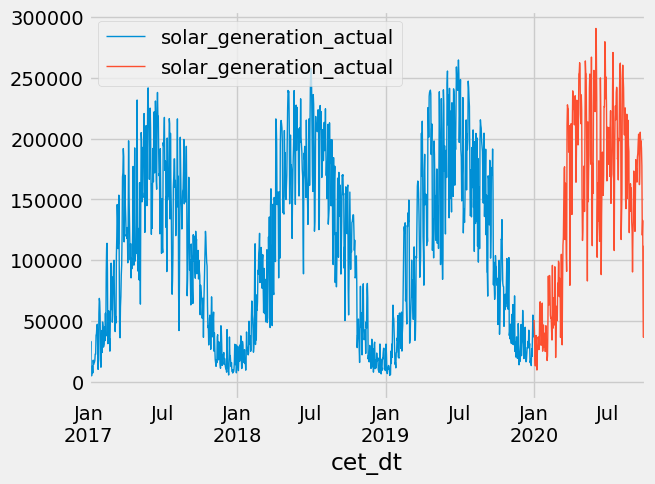

In [49]:
solar_train = solar_ts.loc[:'2019']
solar_test = solar_ts.loc['2020':]

fig, ax = plt.subplots()
solar_train.plot(ax=ax, linewidth=1)
solar_test.plot(ax=ax, linewidth=1)
plt.show()

In [57]:
# weekly:

solar_weekly_ts = ger_weekly_generation_df[['solar_generation_actual']]
weekly_period = 52 # 52 days in year

1

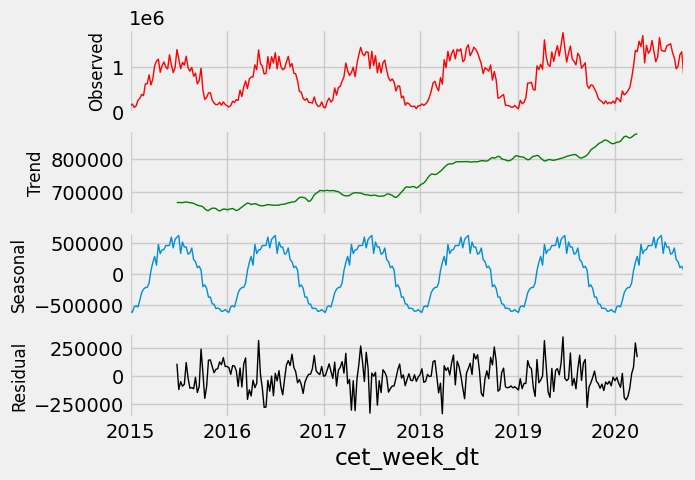

In [58]:
plot_seasonal_components(solar_weekly_ts, weekly_period) # ['solar_generation_actual']

From the decomposition above we can conclude:

- There is a **upward trend**. Therefore, this time series is **not stationary**. 
    - Since our data is not stationary, we need to answer *What differencing will make it stationary?* For this we will use our obtain_adf_kpss_results function to find out how many times we need to apply differencing in order to make this time series stationary. This will be our parameter **d** for the ARIMA model.

- From the **seasonal** component we can observe that the model is **additive**, since the seasonal component is similar (not getting multiplied) over the period of time.

- Also, we can observe on the seasonal component **seasonality** in solar energy generation with lower generation in December-January and higher generation in June-July.
        

<a id="identification_ts0"></a>

## 3.1. Identification

In [59]:
# d

obtain_adf_kpss_results(solar_weekly_ts, 3)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,4.892079e-10,0.1,True,True,True
1,1,3.029011e-04,0.1,True,True,True
2,2,1.058041e-17,0.1,True,True,True


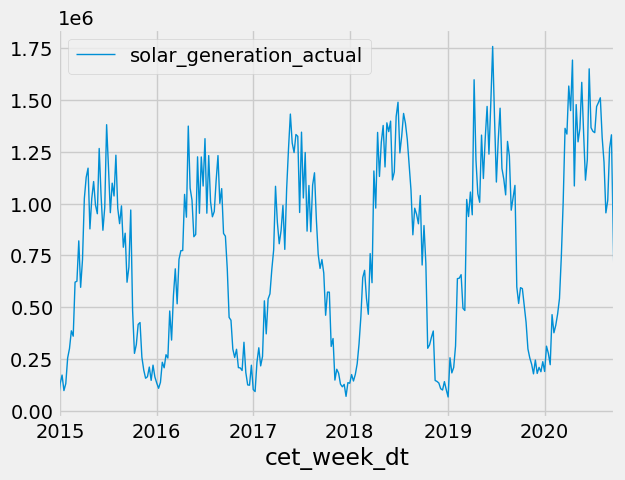

ADF Statistic: -7.072644689206454
p-value: 4.89207899498438e-10
Critical values: {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}


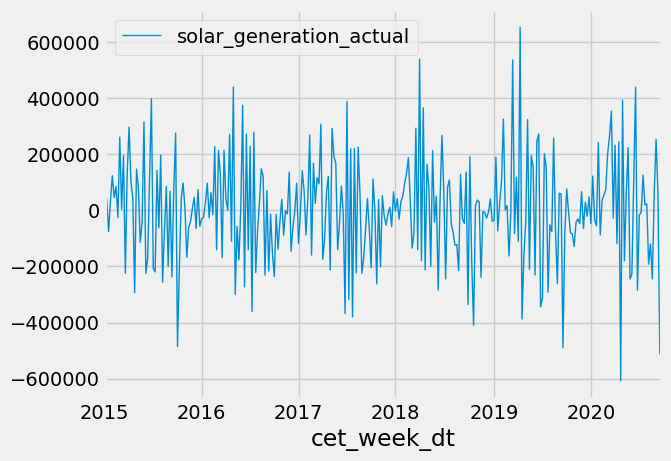

ADF Statistic: -4.395030962439947
p-value: 0.0003029011399663959
Critical values: {'1%': -3.452867117291862, '5%': -2.8714554160827745, '10%': -2.5720532321867466}


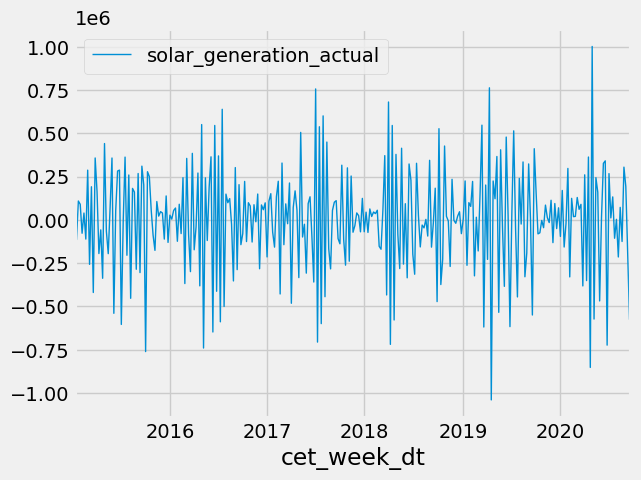

ADF Statistic: -10.101253617621355
p-value: 1.0580408115381865e-17
Critical values: {'1%': -3.453102162983312, '5%': -2.871558538275452, '10%': -2.5721082282996433}


1

In [75]:
# For time series
run_adf_test(solar_weekly_ts, 0)

# For the first difference of the time series
run_adf_test(solar_weekly_ts, 1)

# For the second difference of the time series
run_adf_test(solar_weekly_ts, 2)

Results of stationary tests show that applying differencing only once is enough to make our time series is stationary, i.e., **d = 1**.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


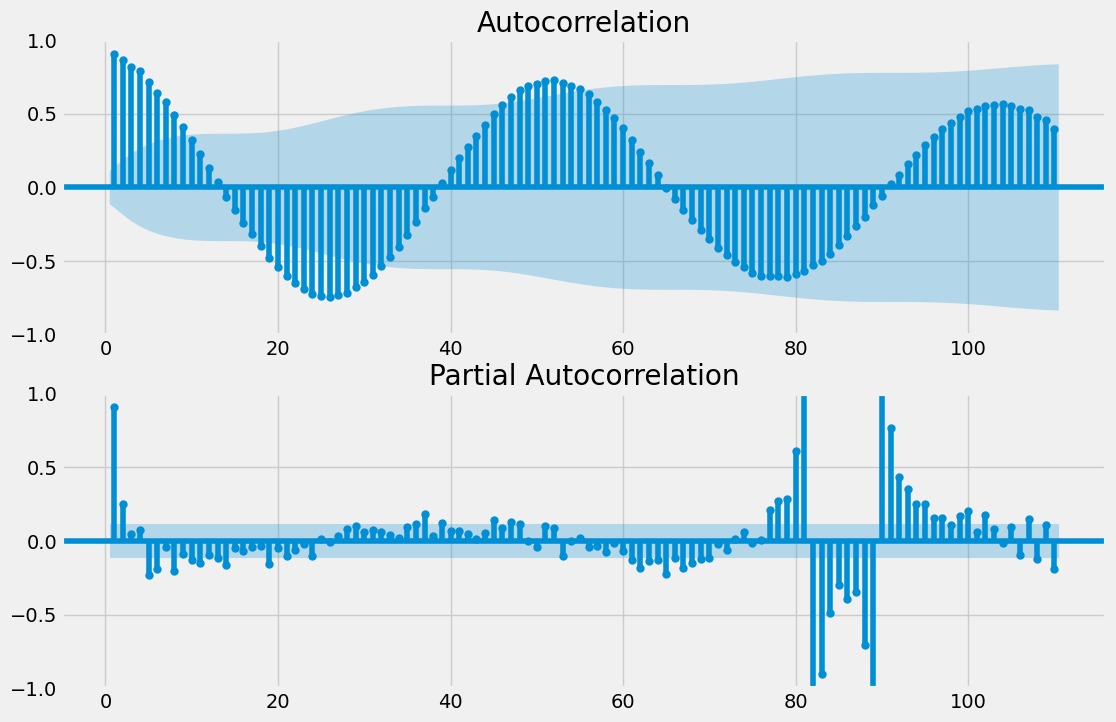

1

In [60]:
plot_acf_pacf(solar_weekly_ts, 110)

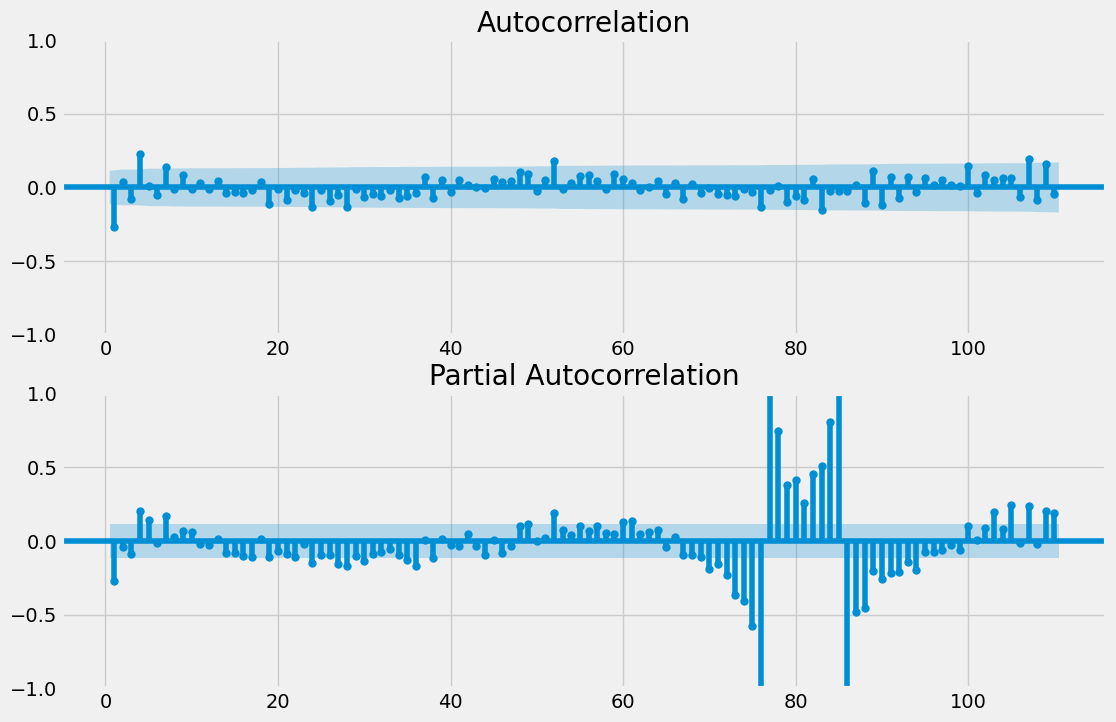

1

In [61]:
plot_acf_pacf(solar_weekly_ts.diff().dropna(), 110)

<a id="estimation_ts0"></a>

## 3.2. Estimation

In [62]:
# p, q

sort_aic_bic(solar_weekly_ts, 1, 11, 11)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

Sorting by AIC:
      p   q          AIC          BIC
105   9   6    32.000000    91.260520
51    4   7  8049.383710  8093.829100
95    8   7  8050.313372  8109.573891
84    7   7  8050.475984  8106.032722
73    6   7  8051.111455  8102.964410
62    5   7  8051.443417  8099.592589
72    6   6  8053.711496  8101.860668
87    7  10  8054.790076  8121.458161
63    5   8  8056.490713  8108.343667
83    7   6  8058.191794  8110.044748
86    7   9  8059.491051  8122.455353
114  10   4  8061.471085  8117.027822
115  10   5  8062.020261  8121.280780
75    6   9  8065.073232  8124.333752
92    8   4  8066.030030  8114.179202
103   9   4  8066.551222  8118.404177
61    5   6  8066.628665  8111.074054
101   9   2  8067.543017  8111.988407
117  10   7  8069.790080  8136.458165
91    8   3  8070.105356  8114.550746

Sorting by BIC:
      p   q          AIC          BIC
105   9   6    32.000000    91.260520
51    4   7  8049.383710  8093.829100
62    5   7  8051.443417  8099.592589
72    6   6  8053

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1

<a id="diagnostics_ts0"></a>

## 3.3. Model diagnostics

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean absolute error from residuals: 117443.35408155061

                                  SARIMAX Results                                  
Dep. Variable:     solar_generation_actual   No. Observations:                  301
Model:                      ARIMA(4, 1, 7)   Log Likelihood               -4012.692
Date:                     Sat, 15 Apr 2023   AIC                           8049.384
Time:                             23:10:45   BIC                           8093.829
Sample:                         12-29-2014   HQIC                          8067.171
                              - 09-28-2020                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3398      0.225      1.512      0.131      -0.101       0.780
ar.L2          1.4811      0.263   

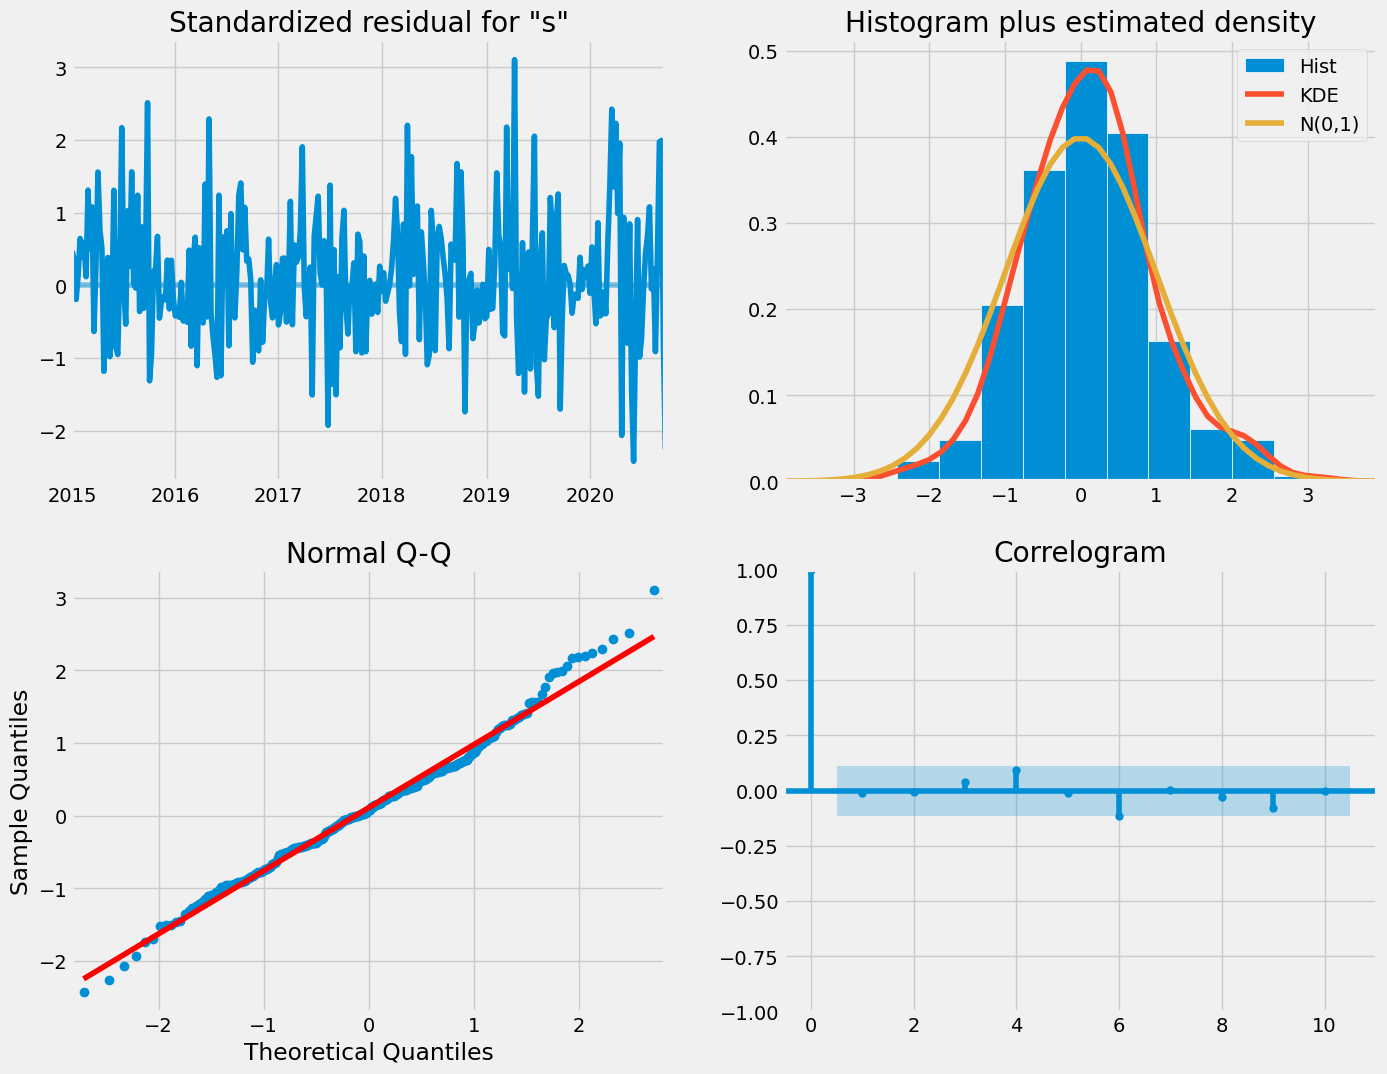

In [64]:
solar_weekly_ts_results = arima_diagnostics(solar_weekly_ts, 4,1,7)

Prob(Q) = 0.84 > 0.05. We shouldn’t reject the null hypothesis that the residuals are uncorrelated so **the residuals are not correlated**. 

Prob(JB) = 0.02 < 0.05. We reject the null hypothesis that the residuals are normally distributed. Therefore, **the residuals are not normally distributed**.

After analyzing of plots:

Therefore, all in all the model pointed by our empirical search seems to be a good model.

<a id="seasonal_ts0"></a>

## 3.4. Seasonal Differencing

In [ ]:
# D

Furthermore, in the case of strong seasonality, as observed in our time series, **D = 1**.

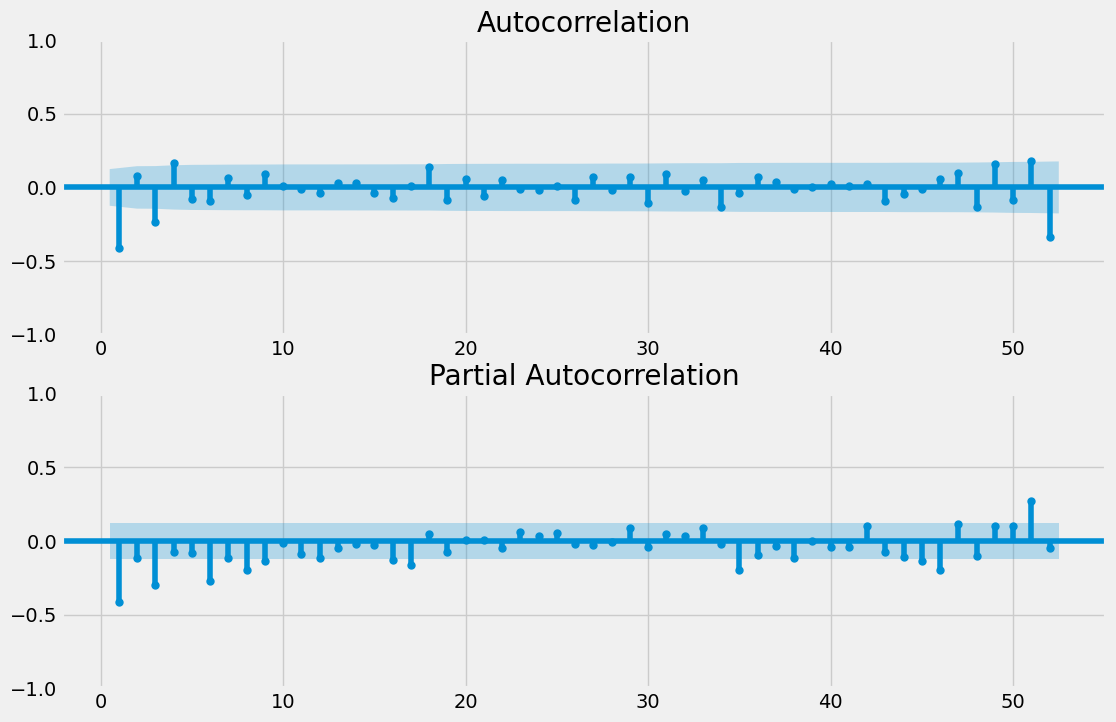

1

In [66]:
# P, Q

plot_acf_pacf(solar_weekly_ts.diff().diff(weekly_period).dropna(), 52)

The Seasonal ACF and PACF plots look like an ARMA(1,1) model, i.e., **P = 1** and **Q = 1**. 


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

Mean absolute error from residuals: 133146.91466653757

                                     SARIMAX Results                                      
Dep. Variable:            solar_generation_actual   No. Observations:                  301
Model:             ARIMA(4, 1, 7)x(1, 1, [1], 52)   Log Likelihood               -3331.264
Date:                            Sun, 16 Apr 2023   AIC                           6690.528
Time:                                    00:11:23   BIC                           6739.716
Sample:                                12-29-2014   HQIC                          6710.329
                                     - 09-28-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3238      0.146     -2.223      0.026    

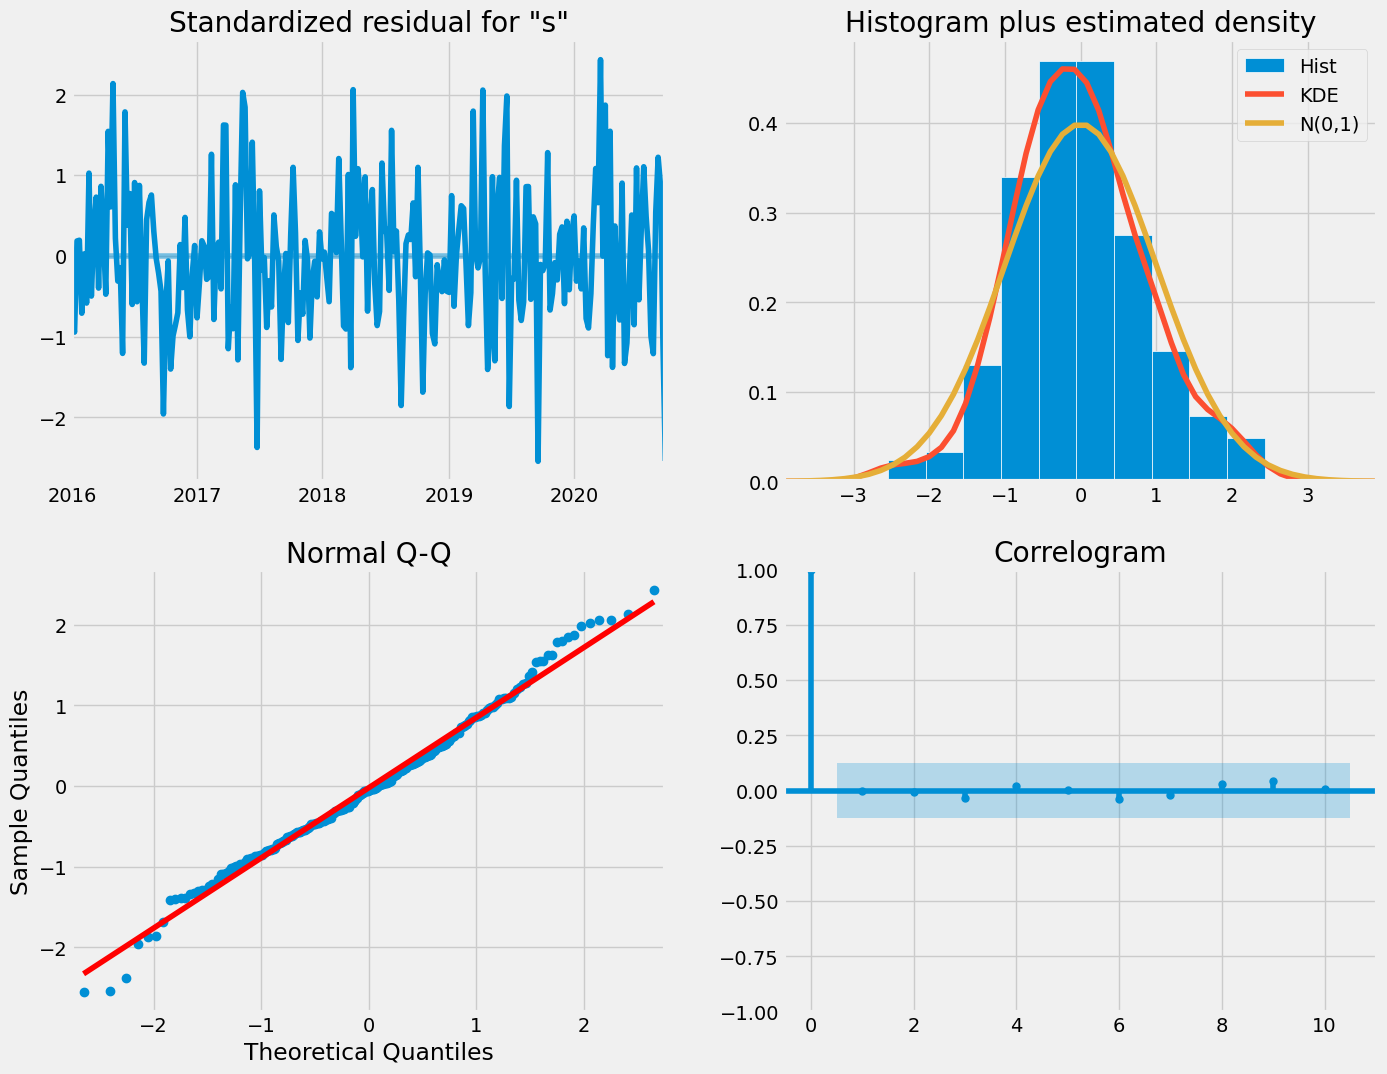

In [67]:
solar_weekly_ts_seasonal_results = sarima_diagnostics(solar_weekly_ts, 4,1,7,1,1,1,52) # 2,1,2,1,1,1  # 6,1,1,0,1,1,52

<a id="forecasting_ts0"></a>

## 3.5. Forecasting

In [68]:
filled_2020_length = (datetime(2020, 10, 1, 0, 0, 0, 0) - datetime(2020, 1, 1, 0, 0, 0, 0)).days
print(filled_2020_length)

rest_2020_length = (datetime(2020, 12, 31, 0, 0, 0, 0) - datetime(2020, 10, 1, 0, 0, 0, 0)).days
print(rest_2020_length)

274
91


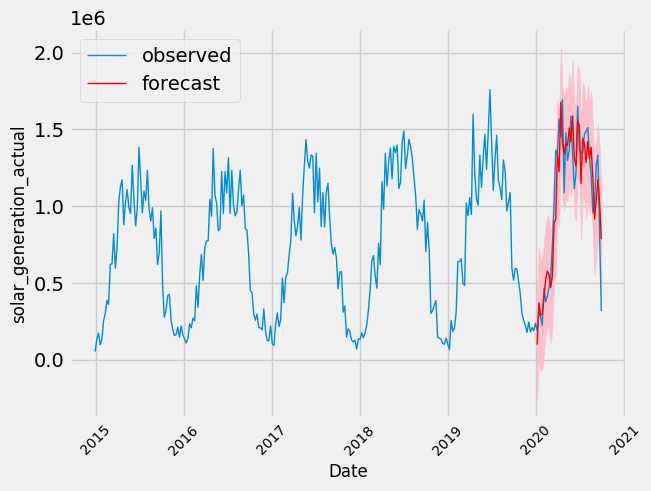

In [69]:
# for non-dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_weekly_ts_seasonal_results, 'solar_generation_actual', filled_2020_length//7, False
)
arima_plot(solar_weekly_ts, mean_predict, lower_limits, upper_limits)


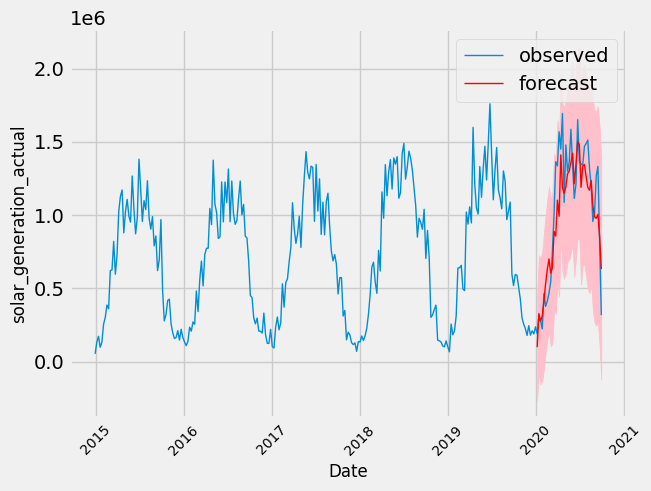

In [70]:
# for dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_weekly_ts_seasonal_results, 'solar_generation_actual', filled_2020_length//7, True
)
arima_plot(solar_weekly_ts, mean_predict, lower_limits, upper_limits)


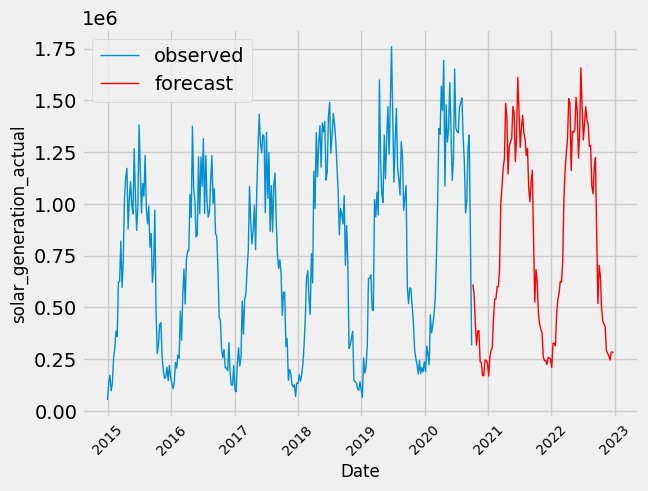

1

In [74]:
solar_weekly_ts_forecast = arima_forecast(solar_weekly_ts_seasonal_results, (rest_2020_length+365*2)//7)
arima_plot_future(solar_weekly_ts, solar_weekly_ts_forecast)

# ===================== THE END ========================    

TODO:
- to describe the project (ReadMe)
- to describe the project (GitHub description + CV)
- to publish the repo

In [100]:
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
def arima_mae_relative(ts, results, days, dynamic=False):
    weeks = days // 7
    one_step_forecast = results.get_prediction(start=-weeks, dynamic=dynamic)
    mean_predict = one_step_forecast.predicted_mean
    
#     pivot_df = pd.concat([ts[-weeks:], mean_predict], axis=1)
#     pivot_df['diff'] = np.abs(pivot_df['solar_generation_actual'] - pivot_df['predicted_mean'])
#     pivot_df['diff_%'] = pivot_df['diff'] / pivot_df['solar_generation_actual']
#     print(pivot_df)
#     print(np.mean(pivot_df['diff_%']))
    
    return mean_absolute_percentage_error(ts[-weeks:], mean_predict)

In [101]:
arima_mae_relative(solar_weekly_ts, solar_weekly_ts_seasonal_results, filled_2020_length, True)

# 0.1967 for False
# 0.1886 for True

0.1885789232559512

In [ ]:
# FOR CHECKING: 

In [ ]:
import pmdarima as pm

In [ ]:
model1 = pm.auto_arima(solar_weekly_ts, #time series
                      seasonal=True, # is the time series seasonal
                      m=52, # the seasonal period - 52 weeks
                      d=1, # non-seasonal difference order
                      D=1, # seasonal difference order
                 	  max_p=7, # max value of p to test 
                      max_q=7, # max value of q to test
                      max_P=3, # max value of P to test 
                      max_Q=3, # max value of Q to test 
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(model1.summary())